Libraries & Parameters

In [1]:
!pip install -q awswrangler

import awswrangler as wr
import pandas as pd

import boto3
import pytz

import numpy as np
!pip install -U -q seaborn
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
from sagemaker import get_execution_role

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [2]:
# Get Sagemaker Role
role = get_execution_role()
print(role)

Couldn't call 'get_role' to get Role ARN from role name AmazonSageMaker-ExecutionRole-20210503T205912 to get Role path.
Assuming role was created in SageMaker AWS console, as the name contains `AmazonSageMaker-ExecutionRole`. Defaulting to Role ARN with service-role in path. If this Role ARN is incorrect, please add IAM read permissions to your role or supply the Role Arn directly.


arn:aws:iam::506926764659:role/service-role/AmazonSageMaker-ExecutionRole-20210503T205912


Runtime Parameters

In [3]:
airline_to_run = 'AA'

___
# 1.) Download Data

## S3 parameters

In [4]:
# Flight data from Sagemaker Data Wrangler
bucket = 'sagemaker-us-west-2-506926764659/export-flow-05-16-30-08-0c003aed/output/data-wrangler-flow-processing-05-16-30-08-0c003aed/b98f4f8c-ddaf-4ee1-99da-b0dd09f47a21/default'
filename = 'part-00000-92fade68-00c4-41b3-9182-593084da2eae-c000.csv'
path_to_file = 's3://{}/{}'.format(bucket, filename)

# # Flight data from entire year of 2011
# bucket = 'from-public-data/carrier-perf/transformed'
# filename = 'airOT2011all.csv'
# path_to_file = 's3://{}/{}'.format(bucket, filename)

# # Flight data from 2011_01 
# bucket = 'from-public-data/carrier-perf/transformed/airOT2011'
# filename = 'airOT201101.csv'
# path_to_file = 's3://{}/{}'.format(bucket, filename)


# ________________________________________________________________
# Supporting dataset useful for EDA and understanding data
#   - airport codes
#   - airline codes
bucket2 = 'from-public-data/carrier-perf/raw'
file_airport = 'airports.csv'
file_airline = 'airlines.csv'

path_to_file_airport = 's3://{}/{}'.format(bucket2, file_airport)
path_to_file_airline = 's3://{}/{}'.format(bucket2, file_airline)

=== === === === ===
## Download data from S3

### 1. Flights Performance dataset

In [5]:
df = wr.s3.read_csv([path_to_file])
# df

A whopping 7,294,649 rows (records) of JUST year 2007!  Thanks to all the Sagemaker Data Wrangler, I was able to already do some data cleaning and adjustment:
  - Create new variable `late_flight` depending on `DEP_DELAY`
  - Trim value to remove outliers for `DEP_DLAY`
  - Drop records for Cancelled flights `CANCELED` == 1 (doesn't make much sense to have flights that's irrelevant to flights delay when flight never occur)

### 2. Airports & Airlines dataset

In [6]:
df_airports = wr.s3.read_csv([path_to_file_airport])
df_airlines = wr.s3.read_csv([path_to_file_airline])
# df_airlines

=== === === === ===
## Initial Data Clean-up and Organization

In [7]:
# rename 'DAY_OF_MONTH' column to 'DAY' (in prep of transforming to datetime format)
df = df.rename(columns={'DAY_OF_MONTH': 'DAY'})
# df

### 1. Date / Time modifications

Make date and time more appropriate.  This will make it easier when making plots.

In [8]:
# Create a datetime field `DATE`
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH','DAY']])

In [9]:
# Convert 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure

In [10]:
df['DEP_TIME'] = df['DEP_TIME'].apply(format_heure)
df['ARR_TIME'] = df['ARR_TIME'].apply(format_heure)

### 2. Organize Columns

Let's organize columns (features) to be more logical

In [11]:
variables_to_remove = ['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID']
df.drop(variables_to_remove, axis = 1, inplace = True)

df = df[[
    'DATE',
    'YEAR',
    'MONTH',
    'DAY',
    'DAY_OF_WEEK',
    'UNIQUE_CARRIER',
    'ORIGIN',
    'DEST',
    'DEP_TIME',
    'DEP_DELAY',
    'DEP_DELAY_no_outlier',
    'ACTUAL_ELAPSED_TIME',
    'AIR_TIME',
    'DISTANCE',
    'ARR_TIME',
    'ARR_DELAY',
    'CARRIER_DELAY',
    'WEATHER_DELAY',
    'NAS_DELAY',
    'SECURITY_DELAY',
    'LATE_AIRCRAFT_DELAY',
    'late_flight']]

In [12]:
# df_toTrain = df.loc[df['UNIQUE_CARRIER'] == 'AA']
df_toTrain = df.loc[df['UNIQUE_CARRIER'] == airline_to_run]

distinct_airlines = df_toTrain.UNIQUE_CARRIER.unique()
print('New dataset has {0} records with {1} variables, containing only airlines {2}'.format(df_toTrain.shape[0], df_toTrain.shape[1], distinct_airlines))

New dataset has 615933 records with 22 variables, containing only airlines ['AA']


In [13]:
df_toTrain

,DATE,YEAR,MONTH,DAY,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,DEP_DELAY,...,AIR_TIME,DISTANCE,ARR_TIME,ARR_DELAY,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,late_flight
20534,2007-01-01,2007,1,1,1,AA,JFK,LAX,08:54:00,-6.0,...,333.0,2475.0,12:30:00,20.0,0.0,0.0,20.0,0.0,0.0,late
20535,2007-01-02,2007,1,2,2,AA,JFK,LAX,08:55:00,-5.0,...,326.0,2475.0,12:35:00,25.0,0.0,0.0,25.0,0.0,0.0,late
20536,2007-01-03,2007,1,3,3,AA,JFK,LAX,08:56:00,-4.0,...,312.0,2475.0,12:13:00,3.0,NaN,NaN,NaN,NaN,NaN,late
20537,2007-01-04,2007,1,4,4,AA,JFK,LAX,09:01:00,1.0,...,352.0,2475.0,12:49:00,39.0,0.0,0.0,39.0,0.0,0.0,late
20538,2007-01-05,2007,1,5,5,AA,JFK,LAX,08:55:00,-5.0,...,360.0,2475.0,13:00:00,50.0,0.0,0.0,50.0,0.0,0.0,late
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6770764,2007-12-29,2007,12,29,6,AA,ORD,MCI,10:02:00,22.0,...,69.0,403.0,11:30:00,25.0,0.0,21.0,3.0,0.0,1.0,late
6770765,2007-12-30,2007,12,30,7,AA,ORD,MCI,09:33:00,-7.0,...,66.0,403.0,10:58:00,-7.0,NaN,NaN,NaN,NaN,NaN,late
6770766,2007-12-31,2007,12,31,1,AA,ORD,MCI,09:36:00,-4.0,...,79.0,403.0,11:23:00,18.0,0.0,0.0,18.0,0.0,0.0,late
6770767,2007-12-13,2007,12,13,4,AA,BOS,MIA,09:15:00,0.0,...,176.0,1258.0,12:56:00,11.0,NaN,NaN,NaN,NaN,NaN,late


___
# 2.) Explorational Data Analysis

## Distribution of Target (dependent) Variable `late_flight`

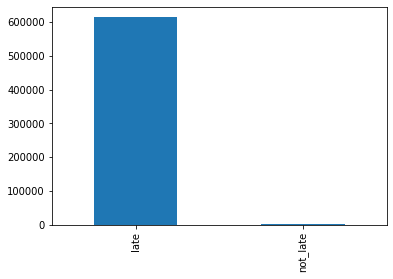

In [14]:
df_toTrain.late_flight.value_counts().plot(kind='bar')

In [15]:
df_toTrain.late_flight.value_counts()

late        614475
not_late      1458
Name: late_flight, dtype: int64

**NOTE** Looks like a pretty imbalance distribution of target variable.  Will probably need to use SMOTE and create synthetic data for the minority class.

## Corrleations

Text(0.5, 1, 'Correlation Heatmap')

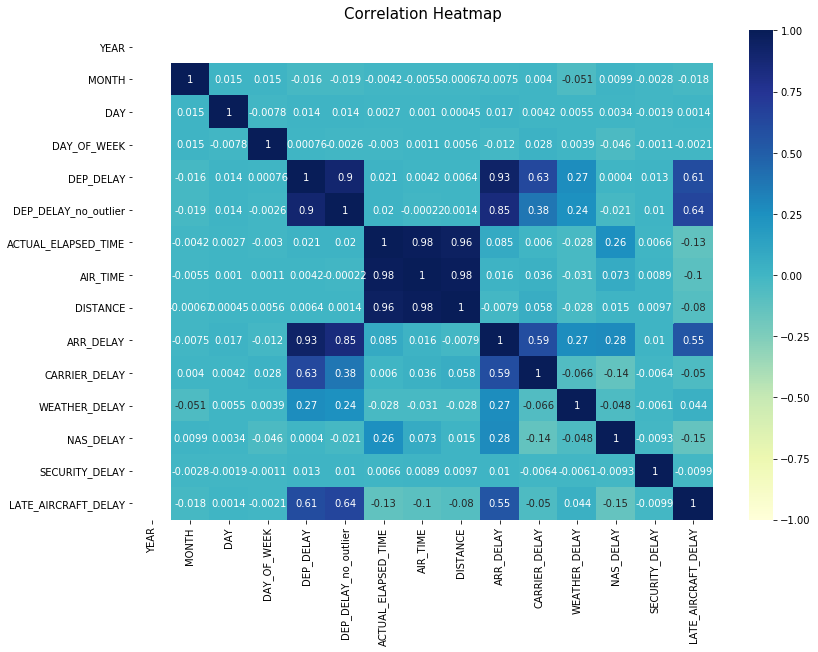

In [16]:
# increase figure size
plt.figure(figsize=(13, 9))
heatmap = sns.heatmap(df_toTrain.corr(), vmin=-1, vmax=1, annot=True, cmap="YlGnBu")

# define title
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':15}, pad=12)

# ref. https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

**NOTE** Looks like high correlation between:
  - `DEP_DELAY_no_outlier` :: `ARR_DELAY`, which could makes logical sense because if you are late departing, then you are likely to be late arriving
  - `ACTUAL_ELAPSED_TIME` :: `DISTANCE` :: `AIR_TIME`, which make sense as each 3-variables are referencing same part of flight

# 3.) Train Model

In [17]:
# Download PyCaret
!pip install pycaret --quiet

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


## a. Get the Data

In [18]:
data = df_toTrain.sample(frac=0.11, random_state=123)
data_unseen = df.drop(data.index)

data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (67753, 22)
Unseen Data For Predictions: (7226896, 22)


## b. Setting Up Environment in PyCaret

In [19]:
from pycaret.classification import *
exp = setup(data = data, 
            numeric_features = ['YEAR', 'MONTH','DAY','DAY_OF_WEEK'],
            ignore_features = ['DEP_DELAY', 'ARR_DELAY', 'AIR_TIME', 'ARR_TIME'],
            target = 'late_flight',
            fix_imbalance = True,
            normalize = True,
            transformation = True,
            ignore_low_variance = True,
            remove_multicollinearity = True,
            multicollinearity_threshold = 0.95,
            use_gpu = True,
            fold = 2
           )

,Description,Value
0,session_id,1680
1,Target,late_flight
2,Target Type,Binary
3,Label Encoded,"late: 0, not_late: 1"
4,Original Data,"(67753, 22)"
5,Missing Values,True
6,Numeric Features,11
7,Categorical Features,5
8,Ordinal Features,False
9,High Cardinality Features,False


## c. Comparing all models

In [20]:
# ref. 
#   -- https://pycaret.readthedocs.io/en/latest/api/classification.html?highlight=compare_models#pycaret.classification.compare_models
#   -- https://machinelearningmastery.com/k-fold-cross-validation/

best_model = compare_models(cross_validation=False)
# best_model = compare_modelfold=old=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9973,0.8373,0.0000,0.0000,0.0000,-0.0002,-0.0005,9.3700
lightgbm,Light Gradient Boosting Machine,0.9970,0.9739,0.0000,0.0000,0.0000,-0.0007,-0.0010,2.0100
et,Extra Trees Classifier,0.9969,0.6651,0.0000,0.0000,0.0000,-0.0008,-0.0011,10.1900
dt,Decision Tree Classifier,0.9951,0.5468,0.0962,0.0877,0.0917,0.0893,0.0894,12.8300
knn,K Neighbors Classifier,0.9859,0.5176,0.0577,0.0124,0.0205,0.0163,0.0214,15.3000
qda,Quadratic Discriminant Analysis,0.9825,0.6364,0.2885,0.0449,0.0777,0.0736,0.1084,1.8000
ada,Ada Boost Classifier,0.9647,0.9698,0.5577,0.0401,0.0748,0.0704,0.1428,9.9300
nb,Naive Bayes,0.9624,0.8085,0.6538,0.0436,0.0817,0.0773,0.1623,0.4800
gbc,Gradient Boosting Classifier,0.9609,0.9709,0.7115,0.0453,0.0853,0.0808,0.1732,43.9500
lr,Logistic Regression,0.8803,0.6681,0.2500,0.0054,0.0106,0.0056,0.0206,10.7500


# 4.) Create Model(s)

## a. Random Forest Classifier

In [21]:
rf = create_model('rf')
# rf = create_model('rf', cross_validation=False)

# trained model object is stored as `rf`
# print(rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9977,0.8579,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.9977,0.7973,0.0000,0.0000,0.0000,0.0000,0.0000
Mean,0.9977,0.8276,0.0000,0.0000,0.0000,0.0000,0.0000
SD,0.0000,0.0303,0.0000,0.0000,0.0000,0.0000,0.0000


## b. Ada Boost Classifier

In [22]:
ada = create_model('ada')
# ada = create_model('ada', cross_validation=False)

# trained model object is stored as `ada`
# print(ada)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9825,0.9766,0.3818,0.0522,0.0919,0.0882,0.1363
1,0.9846,0.9737,0.2963,0.0468,0.0808,0.0772,0.1130
Mean,0.9836,0.9751,0.3391,0.0495,0.0864,0.0827,0.1246
SD,0.0011,0.0014,0.0428,0.0027,0.0055,0.0055,0.0117


## c. Light Gradient Boosting Machine

In [23]:
lightgbm = create_model('lightgbm')
# lightgbm = create_model('lightgbm', cross_validation=False)

# trained model object is stored as `lightgbm`
# print(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9975,0.9766,0.0182,0.1429,0.0323,0.0318,0.0502
1,0.9970,0.9700,0.0000,0.0000,0.0000,-0.0011,-0.0013
Mean,0.9972,0.9733,0.0091,0.0714,0.0161,0.0153,0.0244
SD,0.0003,0.0033,0.0091,0.0714,0.0161,0.0164,0.0258


# 5.) Tune Model(s)

## a. Light Gradient Boosting Machine

In [24]:
tuned_lightgbm = tune_model(lightgbm, n_iter=2, early_stopping=True)

# tuned model object is stored as `tuned_lightgbm`
# print(tuned_lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9975,0.9778,0.0000,0.0000,0.0000,-0.0003,-0.0006
1,0.9975,0.9725,0.0000,0.0000,0.0000,-0.0005,-0.0008
Mean,0.9975,0.9752,0.0000,0.0000,0.0000,-0.0004,-0.0007
SD,0.0000,0.0026,0.0000,0.0000,0.0000,0.0001,0.0001


# 6.) Models Performance

## a. Light Gradient Boosting Machine

### i. Confusion Matrix

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


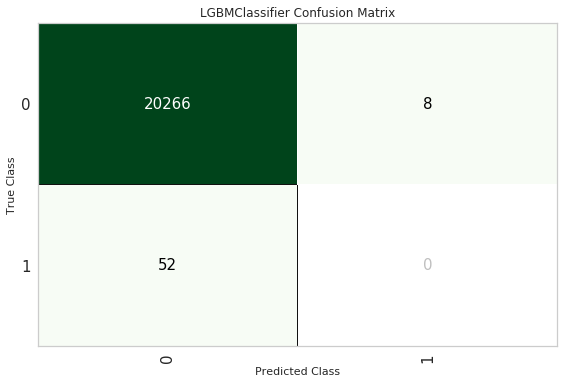

In [25]:
plot_model(tuned_lightgbm, plot = 'confusion_matrix')

### ii. Features Importance

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


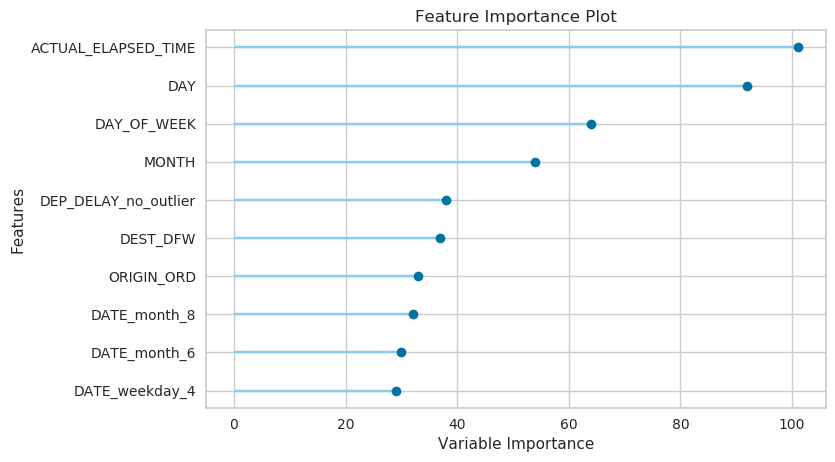

In [26]:
plot_model(tuned_lightgbm, plot='feature')

Features that has greatest explanatory power are:

* `ACTUAL_ELAPSED_TIME`
* `DAY` of the month

### iii. Intrepret Model's with SHAP

ref. 

* https://www.analyticsvidhya.com/blog/2020/05/pycaret-machine-learning-model-seconds/
* https://www.analyticsvidhya.com/blog/2019/11/shapley-value-machine-learning-interpretability-game-theory/?utm_source=blog&utm_medium=pycaret-machine-learning-model-seconds

In [27]:
!apt-get update && apt-get install -y build-essential -q
!python -m pip install -q shap

Hit:1 http://security.debian.org/debian-security buster/updates InRelease
Hit:2 http://deb.debian.org/debian buster InRelease
Hit:3 http://deb.debian.org/debian buster-updates InRelease
Reading package lists... Done
Reading package lists...
Building dependency tree...
Reading state information...
build-essential is already the newest version (12.6).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


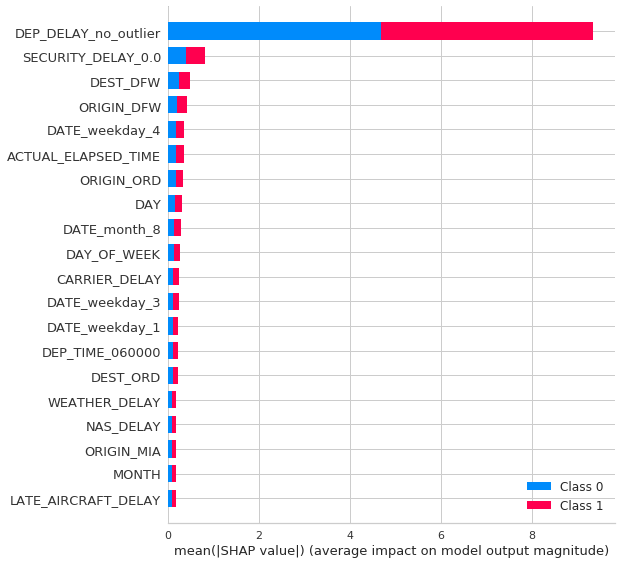

In [28]:
interpret_model(tuned_lightgbm, plot='summary')

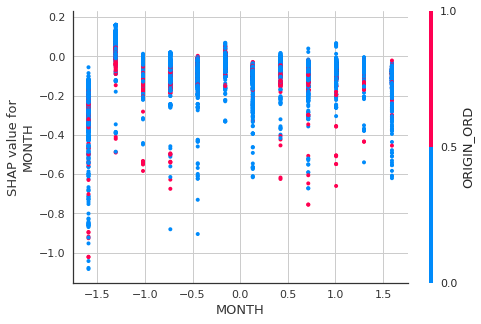

In [29]:
interpret_model(tuned_lightgbm, plot='correlation')

# 8.) Predict of Test Data Sample

## a. Light Gradient Boosting Machine

In [30]:
predict_model(tuned_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9970,0.9724,0.0000,0.0000,0.0000,-0.0007,-0.0010


,MONTH,DAY,DAY_OF_WEEK,DEP_DELAY_no_outlier,ACTUAL_ELAPSED_TIME,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,LATE_AIRCRAFT_DELAY,ORIGIN_ABQ,...,DATE_weekday_2,DATE_weekday_3,DATE_weekday_4,DATE_weekday_5,DATE_weekday_6,DATE_is_month_end_0,DATE_is_month_start_1,late_flight,Label,Score
0,0.423385,1.616396,0.033057,0.413236,0.054627,0.319675,0.431067,0.228617,0.243523,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,late,late,0.9999
1,1.007423,1.281180,1.021557,-0.558437,0.859746,0.319675,0.431067,0.228617,0.243523,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,late,late,0.9999
2,1.300424,-0.529257,1.509871,-0.010713,-0.827452,0.319675,0.431067,0.228617,0.243523,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,late,late,0.9999
3,0.715042,0.607578,0.529700,1.623595,-1.986128,0.755506,-1.575372,-2.216513,0.251674,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,late,late,0.9999
4,-0.445766,1.057159,0.529700,-0.438144,0.483105,-1.831207,-1.575372,1.340678,-1.984431,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,late,late,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20321,1.593967,0.268753,-0.977786,-0.010713,0.570134,0.319675,0.431067,0.228617,0.243523,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,late,late,0.9999
20322,0.715042,-0.185942,0.529700,-1.247715,1.010007,0.319675,0.431067,0.228617,0.243523,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,late,late,0.9999
20323,-1.307146,1.169228,-1.489502,1.498562,0.508274,1.601758,-1.575372,-2.216513,-1.984431,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,late,late,0.9999
20324,0.423385,-1.451525,0.529700,-0.558437,-0.620131,0.319675,0.431067,0.228617,0.243523,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,late,late,0.9999


# 9.) Deploy Model (finalized)

## a. Light Gradient Boosting Machine

In [31]:
final_lightgbm = finalize_model(tuned_lightgbm)

#Final model's parameters for deployment
print(final_lightgbm)

[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
LGBMClassifier(bagging_fraction=0.6, bagging_freq=7, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.4, max_depth=-1,
               min_child_samples=21, min_child_weight=0.001, min_split_gain=

**Caution**: Once the model is finalized using `finalize_model()`, the entire dataset including the test/hold-out set is used for training. As a result, if the model is used for predictions on the hold-out set after `finalize_model()` is used, the information grid printed will be misleading as you are trying to predict on the same data that was used for modeling.

In [32]:
predict_model(final_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9985,0.9985,0.4231,0.9565,0.5867,0.5860,0.6356


,MONTH,DAY,DAY_OF_WEEK,DEP_DELAY_no_outlier,ACTUAL_ELAPSED_TIME,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,LATE_AIRCRAFT_DELAY,ORIGIN_ABQ,...,DATE_weekday_2,DATE_weekday_3,DATE_weekday_4,DATE_weekday_5,DATE_weekday_6,DATE_is_month_end_0,DATE_is_month_start_1,late_flight,Label,Score
0,0.423385,1.616396,0.033057,0.413236,0.054627,0.319675,0.431067,0.228617,0.243523,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,late,late,0.9999
1,1.007423,1.281180,1.021557,-0.558437,0.859746,0.319675,0.431067,0.228617,0.243523,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,late,late,0.9999
2,1.300424,-0.529257,1.509871,-0.010713,-0.827452,0.319675,0.431067,0.228617,0.243523,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,late,late,0.9999
3,0.715042,0.607578,0.529700,1.623595,-1.986128,0.755506,-1.575372,-2.216513,0.251674,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,late,late,1.0000
4,-0.445766,1.057159,0.529700,-0.438144,0.483105,-1.831207,-1.575372,1.340678,-1.984431,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,late,late,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20321,1.593967,0.268753,-0.977786,-0.010713,0.570134,0.319675,0.431067,0.228617,0.243523,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,late,late,1.0000
20322,0.715042,-0.185942,0.529700,-1.247715,1.010007,0.319675,0.431067,0.228617,0.243523,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,late,late,1.0000
20323,-1.307146,1.169228,-1.489502,1.498562,0.508274,1.601758,-1.575372,-2.216513,-1.984431,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,late,late,1.0000
20324,0.423385,-1.451525,0.529700,-0.558437,-0.620131,0.319675,0.431067,0.228617,0.243523,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,late,late,1.0000


# 10.) Predict on Unseen Dataset

In [ ]:
unseen_predictions = predict_model(final_lightgbm, data=data_unseen)
unseen_predictions

In [ ]:
KPI = 'Accuracy'
from pycaret.utils import check_metric
# check_metric(unseen_predictions['late_flight'], unseen_predictions['Label'])
check_metric(unseen_predictions['late_flight'], unseen_predictions['Label'], metric=KPI)

# 11.) Persist Model

In [42]:
today = datetime.datetime.now()
today_datetime = today.strftime("%d-%m-%Y %H:%M:%S")
pkl_filename = 'Final_model___' + 'lightgbm' + '___for_' + airline_to_run + '_' + today_datetime

save_model(final_lightgbm, pkl_filename)

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['DEP_DELAY', 'ARR_DELAY',
                                                        'AIR_TIME', 'ARR_TIME'],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['YEAR', 'MONTH',
                                                           'DAY',
                                                           'DAY_OF_WEEK'],
                                       target='late_flight', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy...
                                 boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, feature_fraction=0.5,
      